# Q5's Teamwork

- Aleksandar Mona Macko Puhek
- Chuying He
- Ioannis Lavdas
- Lorena Mendez
- Pantelis Fragkos

# Introduction

Multipartite entangled GHZ states were first proposed in 1989 <sup>[1]</sup> and experimentally confirmed in 1998 <sup>[2]</sup>. Since then, a number of qubits in entangled GHZ states and a number of quantum computer architectures realizing them has grown <sup>[3]</sup>. Quantum circuits realizing these states consists of parts generating these states and of parts verifying these states. Recently, an entangled GHZ state with 18 qubits was realized on an IBM quantum computer with fidelity of around one half <sup>[4]</sup>.  
<br/>
<i>
[1] arXiv:0712.0921 <br/>
[2] J.-W. Pan and A. Zeilinger, Phys. Rev. A. 57:2208 (1998)  <br/>
[3] C. Song et al, Phys. Rev. Lett. 119:180511 (2017), T. Monz et al, Phys. Rev. Lett. 106:130506 (2011), X.-L. Wang et al, Phys. Rev. Lett. 120:260502 (2018)  <br/>
[4] arXiv:1905..05720v1
</i>

# Idea

In this notebook, we implement two ways of generating a GHZ state tested on a quantum emulator based on an IBM quantum computer. Verification is performed with a multi-qubit metric tested previously on an IBM quantum computer which represents current state-of-the-art according to our knowledge <sup>[Ref. 4 in Introduction]</sup>.  

We use emulators based on the following machine: ibm-lagos (7-qubits).

# Solution

## "Naive" GHZ State

Quantum circuit is built in two parts, generation and verification.

<img src="./assets/graph_naive.png" alt="graph_naive" width="500" />

### 1. Generation
The generation part of the quantum circuit is built with the H-gate at the first qubit and CNOT gate connecting that gate with every other qubit in the circuit. The connection depends on the emulator used and a special coupling map between qubits is prepared.

In [51]:
from qiskit import QuantumCircuit, execute, Aer

def generate_naive_ghz_state(qubit_amount):
    """Prepare a GHZ state with given qubit_amount using naive implementation.

    Args:
        qubit_amount (int): amount of the qubits

    Returns:
        QuantumCircuit: a QuantumCircuit object that generated using naive implementation
    """
    # Initialize a quantum circuit with n qubits
    qc = QuantumCircuit(qubit_amount)

    # Apply a Hadamard gate to the first qubit
    qc.h(0)

    # Apply a CNOT gate between the first qubit and each of the other qubits
    for i in range(1, qubit_amount):
        qc.cx(0, i)

    qc.measure_all()

    return qc

### 2. Verification
The verification part of quantum circuit is built following the refocused MQC (multiple quantum coherence) approach <sup>[4]</sup>. We first add the X-gate to each qubit for noise reduction. We than add an unitary operator equal to a value of angle multiplied with Z-gate and divided by half. Qubits are further connected by CNOT gates in reverse order to that of generation (for clarification of term "reverse order" consult Ref. 4 and Fig. 2D). The H-gate is added to the first qubit.
### 3. Measurement
Measurement is performed. The value of the angle has to be varied around the full circle in discrete steps of e.g. 30 circles (like in Ref. 4) and the circuit has to be run separately for each value.
### 4. Fidelity calculation
Fidelity of the circuit has to be compared to the ideal value for every angle <sup>[4]</sup>.

## Dynamic Circuit GHZ State

### 1. Generation
In this section we build a GHZ state using dynamic circuits. For n qubits we need n-1 ancilla qubits (so in total 2n-1). In this implementation, we put the physical qubits in even positions and the ancillas in odd positions. Then we apply Hadamards to all physical qubits and compare consecutive ones using the ancillas (in a similar way as in bit-flip correction). Using then an if_else statement we create the maximally entangled states. See following code for the general implementation and the circuit for the example of 3 qubits. 

<img src="./assets/graph_dc.png" alt="graph_dc" width="500" />

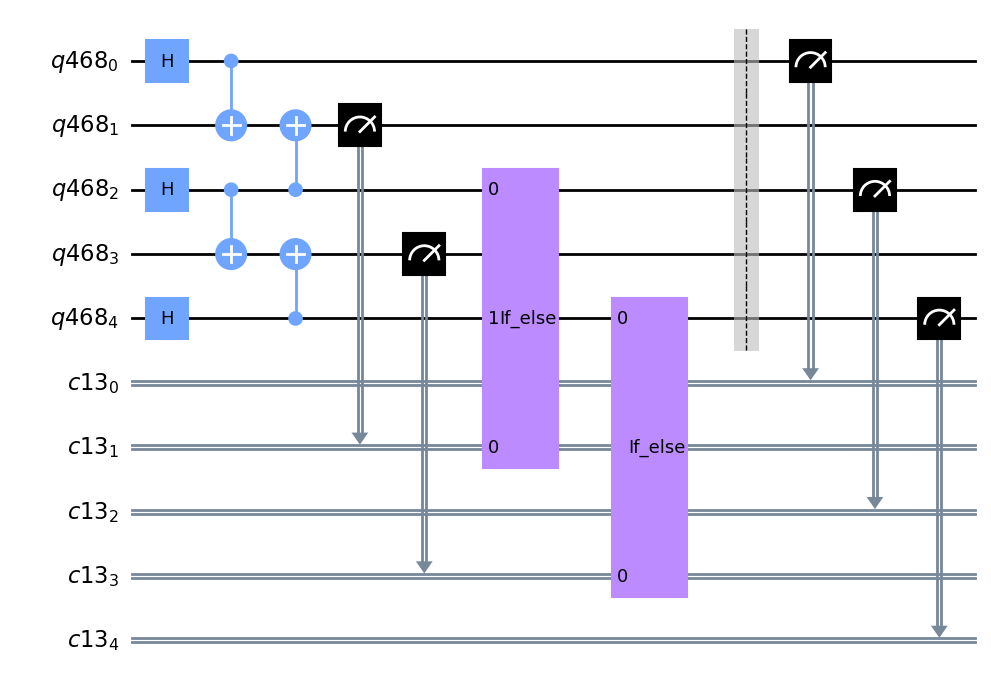

In [96]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def generate_dynamic_circuit_ghz_state(qubit_amount):
    """Prepare a GHZ state with given qubit_amount using DYNAMIC CIRCUIT implementation.

    Args:
        qubit_amount (int): amount of the qubits

    Returns:
        QuantumCircuit: a QuantumCircuit object
    """
    total_qubit_amount = 2*qubit_amount-1
    
    qr = QuantumRegister(total_qubit_amount)
    cr = ClassicalRegister(total_qubit_amount)
    qc = QuantumCircuit(qr, cr)
    
    even_qubit_list = list(range(0,2*qubit_amount,2))
    odd_qubit_list = list(range(1,2*qubit_amount-1,2))
        
    qc.h(even_qubit_list)
    qc.cx(even_qubit_list[:-1], odd_qubit_list)
    qc.cx(even_qubit_list[1:], odd_qubit_list)
    
    qc.measure(qr[1::2], cr[1::2])
    
    # Measure and perform conditional operations
    n = total_qubit_amount
    
    for i in range(1, n, 2):
        with qc.if_test((cr[i], 1)):
            qc.x(list(range(i+1, n, 2)))
    
    qc.barrier()
    
    qc.measure(qr[::2], cr[::2])
    
    return qc

generate_dynamic_circuit_ghz_state(3).draw('mpl')

### 2. Verification
Design of the verification part of the quantum circuit is closely linked with the generation part, but we haven't arrived at the idea for it.

### 3. Measurement
We don't have a proposal.

### 4. Fidelity calculation
We don't have a proposal.

# Results

## Plotting

In [89]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit.providers.fake_provider import FakeSherbrooke

def plot_noise(qc):
    """calculate the distribution of the state

    Args:
        qc (QuantumCircuit): a QuantumCircuit object

    Returns:
        dictionary: a dictionary with state as key, and frequency as value. For example: {'10111': 2, '11010': 1, ...}
    """
    # Fake Provider Backends
    device_backend = FakeSherbrooke()

    sim_sherbrooke = AerSimulator.from_backend(device_backend)

    # Transpile the circuit for the noisy basis gates
    t_qc = transpile(qc, sim_sherbrooke)
    
    # Execute noisy simulation and get counts
    result_noise = sim_sherbrooke.run(t_qc).result()
    counts_noise = result_noise.get_counts(0)
    return counts_noise    

In [83]:
def cluster_counts(counts_noise, qubit_amount):
    """clustered the statistics with only

    Args:
        counts_noise (dictionary): a dictionary with state as key, and frequency as value. For example: {'10011': 2, '11011': 1, ...}
        qubit_amount (int): amount of the qubits

    Returns:
        dictionary: clustered dictionary with only necessary key  For example: {'101': 3, ...}
    """
    new_counts = {}
    for el in counts_noise: 
        even_list = [el[i] for i in range(0, qubit_amount*2-1, 2)]
        try:
            new_counts["".join(even_list)] = new_counts["".join(even_list)] + counts_noise[el]
        except:
            new_counts["".join(even_list)] = counts_noise[el]
    return new_counts

## Run

In [93]:
# INPUT VARIABLE
qubit_amount=5

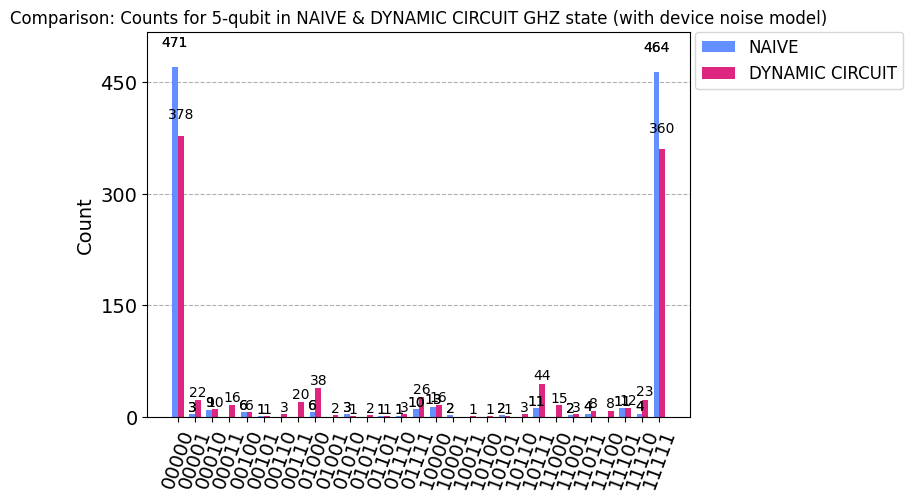

In [95]:
# PLOTTING NAIVE & DYNAMIC CIRCUIT GHZ STATE
## NAIVE
naive_qc = generate_naive_ghz_state(qubit_amount)
naive_counts_noise = plot_noise(naive_qc)

## DYNAMIC CIRCUIT
dc_qc = generate_dynamic_circuit_ghz_state(qubit_amount)
dc_counts_noise=plot_noise(dc_qc)
clusterd_dc_counts_noise = cluster_counts(dc_counts_noise, qubit_amount)

## PLOTTING
legend = ["NAIVE", "DYNAMIC CIRCUIT"]
plot_histogram([naive_counts_noise,clusterd_dc_counts_noise],
               legend=legend,
               title=f"Comparison: Counts for {qubit_amount}-qubit in NAIVE & DYNAMIC CIRCUIT GHZ state (with device noise model)")

# TODO

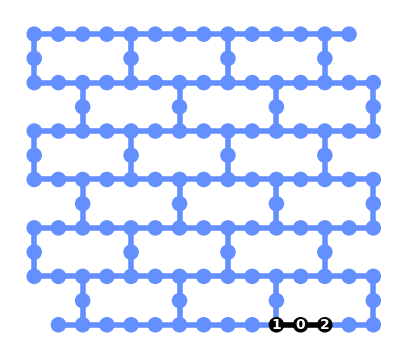

In [91]:
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeSherbrooke, FakeLagosV2

# Fake Provider Backends
device_backend = FakeSherbrooke()

sim_sherbrooke = AerSimulator.from_backend(device_backend)

# Transpile the circuit for the noisy basis gates
t_qc = transpile(naive_qc, sim_sherbrooke)

plot_circuit_layout(t_qc, device_backend)

In [58]:
from qiskit.providers.models import BackendConfiguration
# BackendConfiguration(device_backend, coupling_map)
print(device_backend.coupling_map)

print(device_backend.num_qubits)

[[5, 4], [4, 5], [3, 1], [1, 3], [5, 6], [6, 5], [5, 3], [3, 5], [2, 1], [1, 2], [0, 1], [1, 0]]
7
